# Denoising autoencoders


## Required library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras import layers
from keras.models import load_model
from skimage.util import random_noise

2021-12-08 20:05:27.154988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 20:05:27.155038: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load dataset and normalize data

In [2]:
data = pd.read_csv('Mnist-digit/mnist.csv')
y=data.pop('label')
x=data
x=x.values.reshape((-1,28,28,1)) /255.0

## Train-Test Split

In [3]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=0)
sss.get_n_splits(x, y)
print(sss)

for train_index, test_index in sss.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.33,
            train_size=None)
TRAIN: [30512  3538 40571 ... 31149 25562 30468] TEST: [18527 12538 34481 ... 35846 26037  6952]
TRAIN: [ 4806 20259 31193 ... 30115 26552 19138] TEST: [13022 10452 32436 ... 21135 34707 14791]
TRAIN: [38342 19007  3097 ...  7655 37617 23869] TEST: [23472 36446 29580 ... 25953  6950 38604]
TRAIN: [34245  2197 41386 ... 26851 36067 37364] TEST: [ 4778 16086 27235 ...  3346  6073 35709]
TRAIN: [ 1605 37376 38709 ... 20374 26388 24728] TEST: [21681 14258 24661 ... 40966 17466 22461]


## Apply a Gaussian noise matrix and split the images between 0 and 1

Compared to the previous convolutional autoencoder, we will add noise to the images to improve the quality of the reconstruction.

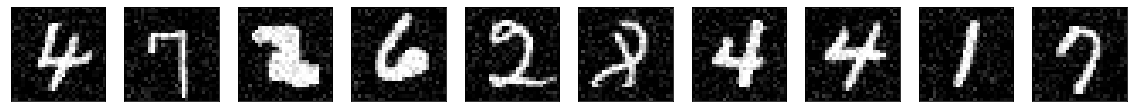

In [4]:
percentage = 0.1
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) * percentage
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) * percentage

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Compile model

In [5]:
keras.backend.clear_session()

input_img = keras.Input(shape=(28, 28, 1))
## encoder layers
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

## decoder layers ##
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

2021-12-08 20:06:10.802969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-08 20:06:10.804853: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 20:06:10.805213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (920bc14734ab): /proc/driver/nvidia/version does not exist
2021-12-08 20:06:10.810794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Compile model

In [6]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

## Train the convolutional autoencoder

In [7]:
BS = 32
EPOCHS = 25
his = autoencoder.fit(x_train_noisy, x_train,
validation_data=(x_test_noisy, x_test),
epochs=EPOCHS,
batch_size=BS)

2021-12-08 20:06:11.880839: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 88247040 exceeds 10% of free system memory.
2021-12-08 20:06:12.457433: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 88247040 exceeds 10% of free system memory.
2021-12-08 20:06:13.738672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
879/880 [============================>.] - ETA: 0s - loss: 0.1852

2021-12-08 20:07:22.213367: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43464960 exceeds 10% of free system memory.
2021-12-08 20:07:22.973520: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43464960 exceeds 10% of free system memory.


880/880 [==============================] - 97s 104ms/step - loss: 0.1852 - val_loss: 0.1372
Epoch 2/25
880/880 [==============================] - 66s 74ms/step - loss: 0.1276 - val_loss: 0.1213
Epoch 3/25
880/880 [==============================] - 53s 61ms/step - loss: 0.1181 - val_loss: 0.1147
Epoch 4/25
880/880 [==============================] - 58s 66ms/step - loss: 0.1130 - val_loss: 0.1118
Epoch 5/25
880/880 [==============================] - 66s 75ms/step - loss: 0.1095 - val_loss: 0.1090
Epoch 6/25
880/880 [==============================] - 62s 71ms/step - loss: 0.1070 - val_loss: 0.1055
Epoch 7/25
880/880 [==============================] - 64s 72ms/step - loss: 0.1051 - val_loss: 0.1040
Epoch 8/25
880/880 [==============================] - 64s 72ms/step - loss: 0.1035 - val_loss: 0.1028
Epoch 9/25
880/880 [==============================] - 54s 62ms/step - loss: 0.1021 - val_loss: 0.1013
Epoch 10/25
880/880 [==============================] - 58s 65ms/step - loss: 0.1009 - val_lo

## Present Results

#### plot diagnostic learning curves

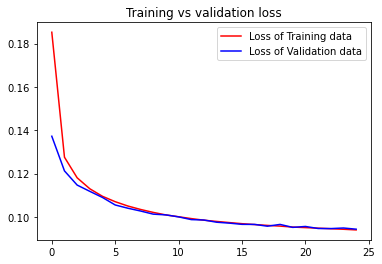

<Figure size 432x288 with 0 Axes>

In [8]:
get_loss = his.history['loss']
validation_loss = his.history['val_loss']
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Comments

The training process has been stable and shows no signs of over-adjustment.

## noise_denoise pipeline

In [9]:
def noise_denoise_image(image, noise_percentage, autoencoder): # 10% of noise
    noisy_image= np.clip(image + (np.random.normal(loc=0.0, scale=1.0,size=image.shape) * noise_percentage), 0., 1.)
    noisy_image = noisy_image.reshape(1,28, 28, 1)
    denoised_image = autoencoder.predict(noisy_image)
    return noisy_image, denoised_image

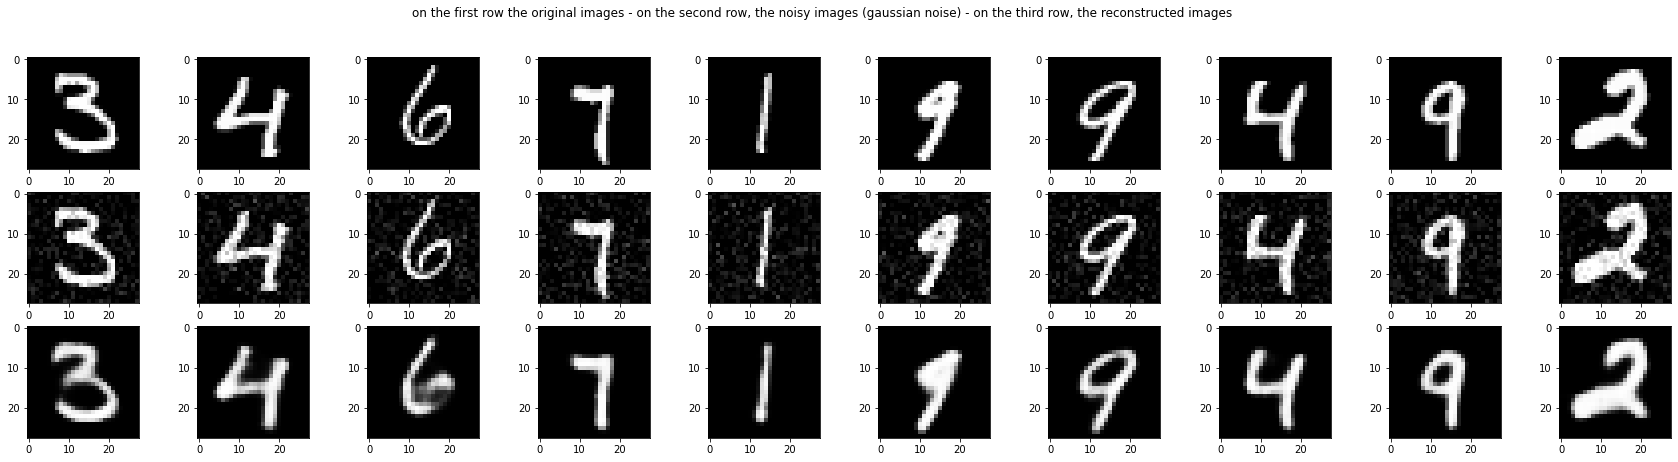

In [10]:
l1 = []
l2 = []
l3 = []
for i in range(10):
    noisy_image, denoised_image = noise_denoise_image(x_test[i], 0.1, autoencoder)
    l1.append(x_test[i])
    l2.append(noisy_image.reshape(28, 28,1))
    l3.append(denoised_image.reshape(28, 28,1))
l4 = [*l1, *l2, *l3]
fig=plt.figure(figsize=(30, 7))
for n in range(30):
    ax=fig.add_subplot(3, 10, n+1)
    ax.imshow(l4[n])
fig.suptitle("on the first row the original images - on the second row, the noisy images (gaussian noise) - on the third row, the reconstructed images")  
plt.show()
    
plt.show()

## Test 4 types of perturbations. 

In [11]:
""""
'gauss'     Gaussian-distributed additive noise.
'poisson'   Poisson-distributed noise generated from the data.
's&p'       Replaces random pixels with 0 or 1.
'speckle'   Multiplicative noise using out = image + n*image,where n is uniform noise with specified mean & variance.
"""
def noisy_2(noise_typ,image):
    if noise_typ == "gauss":
        noise_percentage = 0.1
        noisy_image= np.clip(image + (np.random.normal(loc=0.0, scale=1.0,size=image.shape) * noise_percentage), 0., 1.)
        noisy_image = noisy_image.reshape(1,28, 28, 1)
        denoised_image = autoencoder.predict(noisy_image)
        return noisy_image, denoised_image
    
    elif noise_typ == "s&p":
        prob = 0.1
        rnd = np.random.rand(image.shape[0], image.shape[1])
        noisy_im = image.copy()
        noisy_im[rnd < prob] = 0
        noisy_im[rnd > 1 - prob] = 1
        noisy_image = noisy_im.reshape(1,28, 28, 1)       
        denoised_image = autoencoder.predict(noisy_image)
        return noisy_im, denoised_image
    
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy_im = np.random.poisson(image * vals) / float(vals)
        noisy_image = noisy_im.reshape(1,28, 28, 1)
        denoised_image = autoencoder.predict(noisy_image)
        return noisy_im, denoised_image
    
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)
        noisy_im = image + image * gauss
        noisy_image = noisy_im.reshape(1,28, 28, 1)
        denoised_image = autoencoder.predict(noisy_image)
        return noisy_im, denoised_image



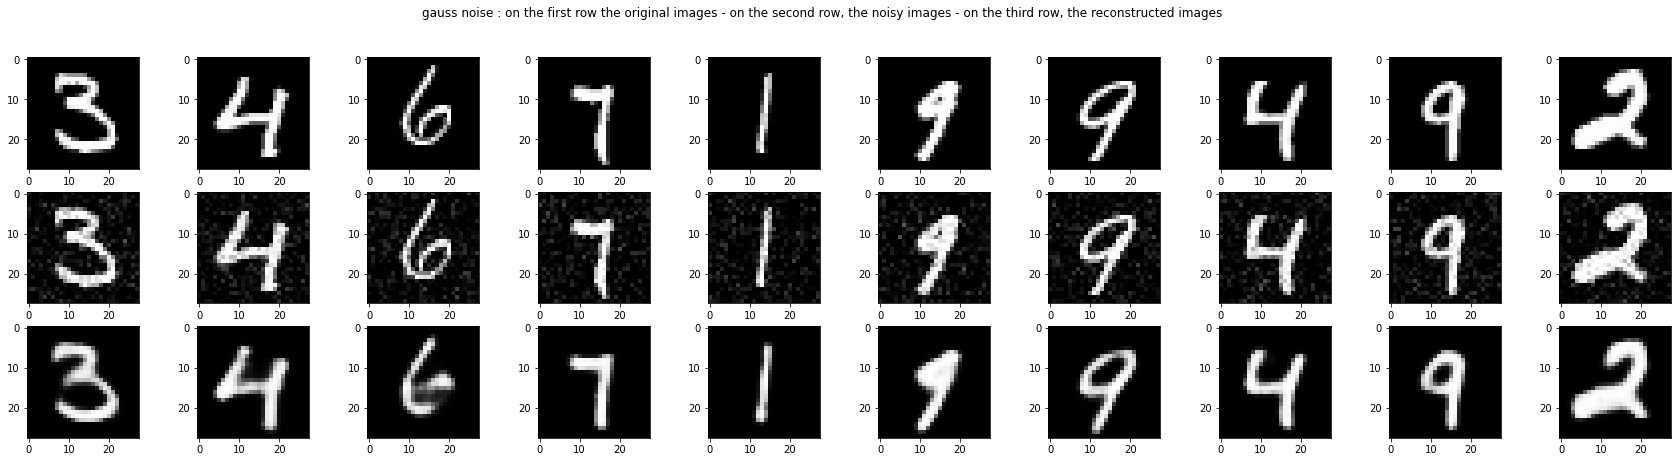

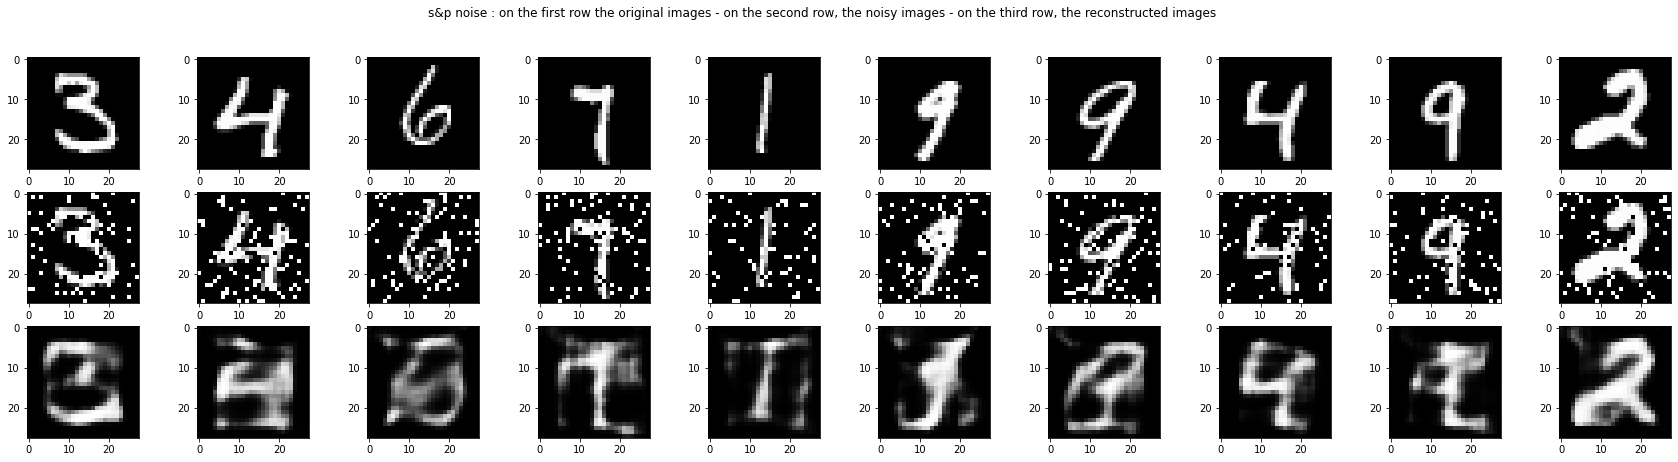

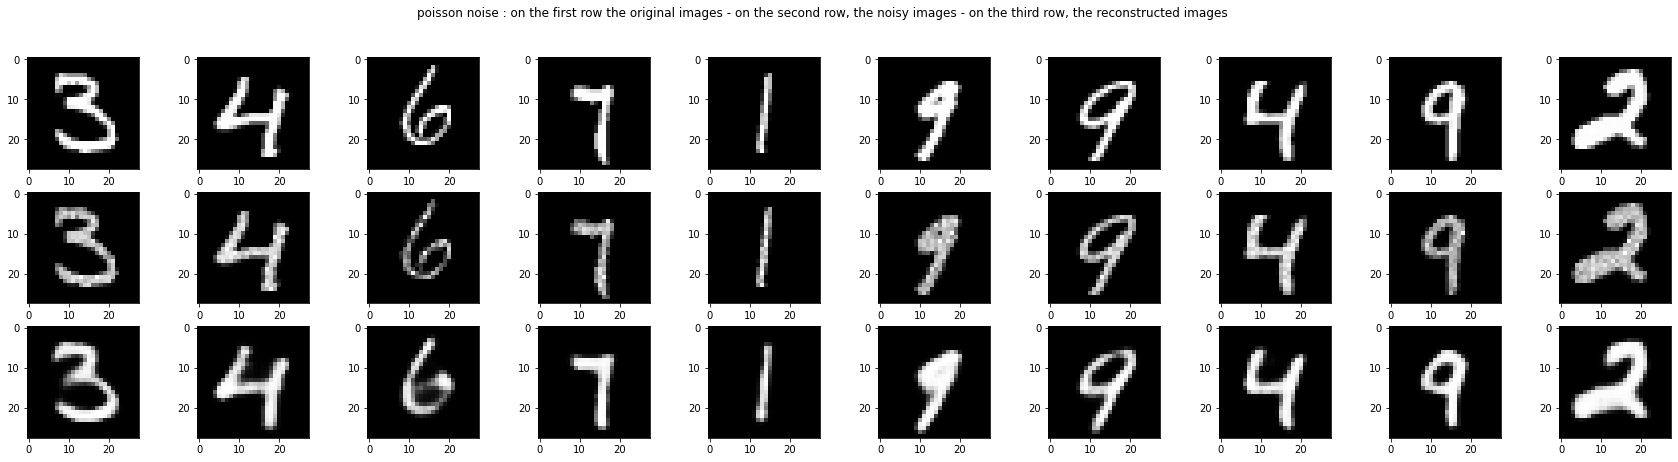

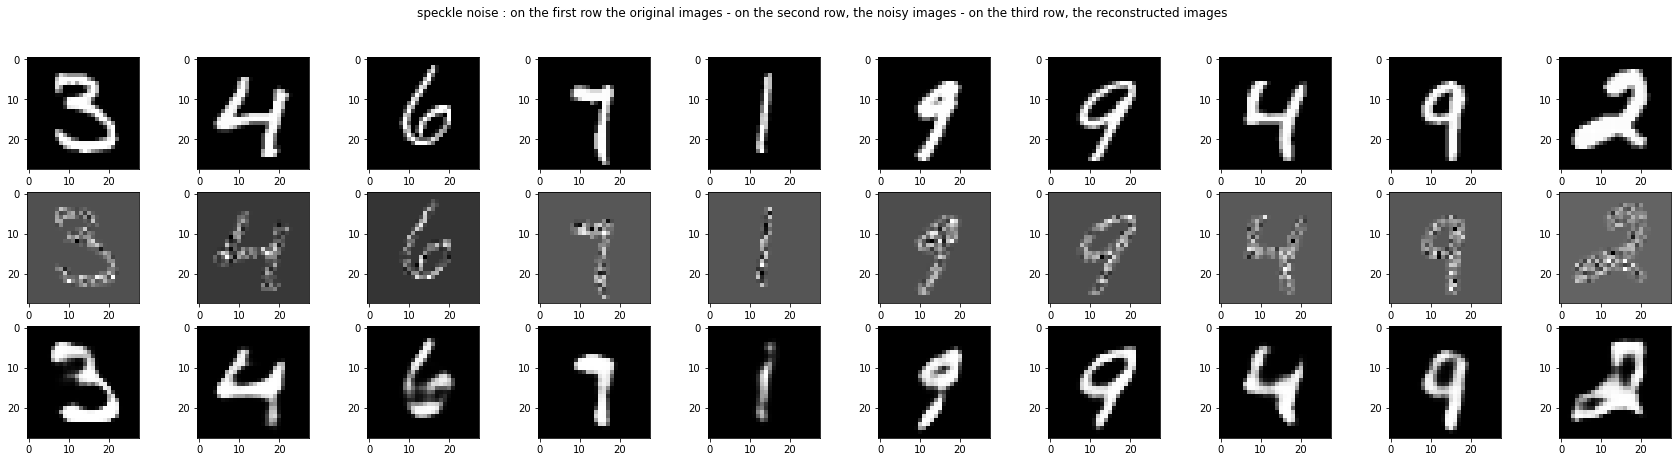

In [12]:
# Tests:
noise_type = ['gauss', 's&p', 'poisson', 'speckle']
for mode in noise_type:
    l1 = []
    l2 = []
    l3 = []
    for i in range(10):
        noisy_image, denoised_image = noisy_2(mode ,x_test[i])
        l1.append(x_test[i])
        l2.append(noisy_image.reshape(28, 28,1))
        l3.append(denoised_image.reshape(28, 28,1))
    l4 = [*l1, *l2, *l3]
    #plt.figure(figsize=(30, 7))
    fig=plt.figure(figsize=(30, 7))
    for n in range(30):
        ax=fig.add_subplot(3, 10, n+1)
        ax.imshow(l4[n])
    fig.suptitle(str(mode) + " noise : on the first row the original images - on the second row, the noisy images - on the third row, the reconstructed images")  
plt.show()

Our model was trained on images with Gaussian noise, which explains the inefficiency of the model on the images when we change the type of noise